In [32]:
import pandas as pd
import bambi as bmb
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format


df = pd.read_csv("data/df_indi_works_occupations.csv", index_col=0)

In [33]:


regions = pd.read_csv(
    "data/ENS - Cultural Index - Countries Databases - region_level.csv"
)
regions["region_name"][regions["region_name"] == "Slav world"] = "East Slavic"
regions = regions[regions["level"] == 2]
regions = regions[regions["region_name"] != "Balkans"]
regions = regions[
    regions["region_name"] != "Eastern Europe"
]  # remove because it takes East Slavic and Central Europe
regions = set(regions["region_name"])
df = df[df["region_name"].isin(regions)]

df["century"] = df["decade"].round(-2)
# Avoid overlapping with Antiquity

df = df[~((df["region_name"] == "Italy") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Portugal") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Spain") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Arabic world") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Balkans") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "France") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "United Kingdom") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Low countries") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "East Slavic") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Central Europe") & (df["decade"] < 500))]
#df = df[~((df["region_name"] == "Eastern Europe") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "German world") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Latin world") & (df["decade"] > 500))]


df["count"] = df["count_works"]
df_m = df.copy()
df_m = df_m[df_m["count"].isin({0, 1, 2})]  # Not more ?
df_m["y"] = df_m["count"].map({0: 0, 1: 0, 2: 1})



In [34]:
set(df_m.region_name)

{'Arabic world',
 'Central Europe',
 'Chinese world',
 'East Slavic',
 'France',
 'German world',
 'Greek World',
 'Indian world',
 'Italy',
 'Japan',
 'Korea',
 'Latin World',
 'Low countries',
 'Nordic countries',
 'Persian world',
 'Portugal',
 'Spain',
 'United Kingdom'}

In [35]:
df_distribution = df_m[['individual_wikidata_id','occupation']].drop_duplicates()
df_distribution.occupation.value_counts()

occupation
Painter                   20226
Scientist                 18477
Musician                  14647
Poet                       9982
Writer                     9150
Theologian                 7689
Architect                  7469
Historian                  7408
Sculptor                   6858
Visual Artist              3626
Theater-related Artist     3244
Name: count, dtype: int64

In [36]:
df_count_work_model = df_m.copy()
df_count_work_model['count_works'][df_count_work_model['count_works']==0] = 1
df_count_work_model = df_count_work_model.groupby(['region_name'])['count_works'].sum().reset_index()
df_count_work_model = df_count_work_model.rename(columns = {'count_works':'count_works_f1_f2'})


In [37]:
# knots
num_knots = 10
knots = np.linspace(df["century"].min(), df["century"].max(), num_knots)
iknots = knots[1:-1]

sample = df_m.copy()
#sample = sample.sample(2000, random_state=42)

In [38]:
#MODEL 3
equation = 'y ~ bs(decade, knots=iknots, intercept=True) + occupation +(1|region_name)'
# SECOND MODEL
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5))
}

base_model = bmb.Model(
    equation, 
    sample, 
    family='bernoulli', 
    priors=priors)


base_model_fitted = base_model.fit(
    draws=1000,
    chains=4,
    inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True},
)  # important to run faster and sample more efficiently


Modeling the probability that y==1
Compiling...
/home/charles/.venv/lib/python3.10/site-packages/pymc/sampling/jax.py:687: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
Compilation time = 0:00:02.073920
Sampling...
sample: 100%|██████████| 2000/2000 [04:21<00:00,  7.64it/s, 127 steps of size 2.60e-02. acc. prob=0.91]
Sampling time = 0:18:02.633658
Transforming variables...
Transformation time = 0:00:00.215874
Computing Log Likelihood...
Log Likelihood time = 0:00:00.518081


In [39]:
#region = 'France'
#occupation = 'Architecture'
new_data = {}

#data = df_m[df_m["region_name"] == region]
data = df_m.copy()
new_data["decade"] = data["decade"].values
new_data["occupation"] = data["occupation"].values
new_data["region_name"] =  data["region_name"].values

new_data = pd.DataFrame(new_data)

base_model.predict(base_model_fitted, data=new_data)
posterior_stacked = az.extract(base_model_fitted)
#p = posterior_stacked['y_mean'].values

y_hat = posterior_stacked["y_mean"].values
y_mean = y_hat.mean(axis=1)
hdi_data = np.quantile(y_hat, [0.11, 0.89], axis=1)

In [40]:
# Création du dataset

data['y_mean'] = y_mean
data['y_min'] = hdi_data[0]
data['y_max'] = hdi_data[1]

In [41]:
def compute_f0(p):
    l = (2 * p) / (1 - p)
    f0 = 1 / (l + (l**2) / 2)
    return f0

def compute_f1(y):
    if y ==0:
        return 1
    else:
        return 0

def compute_f2(y):
    if y == 1:
        return 1
    else:
        return 0

data['f0'] = data['y_mean'].apply(lambda x : compute_f0(x))
data['max_f0'] = data['y_min'].apply(lambda x : compute_f0(x))
data['min_f0'] = data['y_max'].apply(lambda x : compute_f0(x))

data['f1'] = data['y'].apply(compute_f1)
data['f2'] = data['y'].apply(compute_f2)

data.to_csv('results/occupation/raw_results.csv')

### Plot Summary table

In [42]:
# Get results for every region
data_group = data.groupby(['region_name']).agg({'f0':'sum', 'min_f0':'sum', 'max_f0':'sum', 'f1':'sum', 'f2':'sum', 'individual_wikidata_id':'count'}).reset_index()
data_group = data_group.rename(columns={'individual_wikidata_id':'N'})

# Get the full number of unseen individuals
data_group['N_unseen'] = data_group['f0'] +  data_group['f1'] +  data_group['f2'] #count ?
data_group['N_unseen_min'] = data_group['min_f0'] +  data_group['f1'] +  data_group['f2']
data_group['N_unseen_max'] = data_group['max_f0'] +  data_group['f1'] +  data_group['f2']

# Merge with the works
df_all_works = df.groupby(['region_name'])['count_works'].sum().reset_index()
data_group = pd.merge(df_all_works, data_group, on = 'region_name')
data_group = data_group.rename(columns={'count_works':'count_works_all'})
data_group = pd.merge(df_count_work_model, data_group, on = 'region_name')


# Compute metrics
data_group['completeness'] = data_group['N']/ data_group['N_unseen']
data_group['coverage'] = 1 - data_group['f1']/ data_group['count_works_all']

# Reorder and format the results
data_group = data_group.set_index('region_name')
data_group = data_group[['N', 'f1', 'f2', 'f0', 'N_unseen', 'completeness','coverage', 'count_works_all', 'count_works_f1_f2','min_f0', 'max_f0', 'N_unseen_min', 'N_unseen_max']]
data_group = data_group.T
data_group


region_name,Arabic world,Central Europe,Chinese world,East Slavic,France,German world,Greek World,Indian world,Italy,Japan,Korea,Latin World,Low countries,Nordic countries,Persian world,Portugal,Spain,United Kingdom
N,1088.00,8500.00,1504.00,3919.00,17841.00,29339.00,1103.00,412.00,14225.00,949.00,179.00,294.00,7233.00,5414.00,475.00,718.00,5026.00,10689.00
f1,1019.00,8295.00,1380.00,3797.00,16719.00,28382.00,1045.00,378.00,13671.00,886.00,169.00,257.00,6702.00,5163.00,450.00,694.00,4786.00,9984.00
f2,69.00,205.00,124.00,122.00,1122.00,957.00,58.00,34.00,554.00,63.00,10.00,37.00,531.00,251.00,25.00,24.00,240.00,705.00
f0,11885.93,352952.57,10650.54,109167.47,273702.14,1036374.77,15499.06,3780.91,435425.89,8705.38,1914.64,1195.92,99476.76,121575.71,5661.60,19414.89,123529.00,155366.45
N_unseen,12973.93,361452.57,12154.54,113086.47,291543.14,1065713.77,16602.06,4192.91,449650.89,9654.38,2093.64,1489.92,106709.76,126989.71,6136.60,20132.89,128555.00,166055.45
completeness,0.08,0.02,0.12,0.03,0.06,0.03,0.07,0.10,0.03,0.10,0.09,0.20,0.07,0.04,0.08,0.04,0.04,0.06
coverage,0.96,0.61,0.97,0.84,0.85,0.62,0.84,0.69,0.73,0.85,-0.48,0.87,0.91,0.80,0.75,0.72,0.71,0.94
count_works_all,25733.00,21141.00,51841.00,23953.00,114070.00,75168.00,6359.00,1216.00,50816.00,5948.00,114.00,2016.00,76948.00,26123.00,1833.00,2491.00,16677.00,161833.00
count_works_f1_f2,1157.00,8705.00,1628.00,4041.00,18963.00,30296.00,1161.00,446.00,14779.00,1012.00,189.00,331.00,7764.00,5665.00,500.00,742.00,5266.00,11394.00
min_f0,9794.66,308337.75,9163.13,94397.57,243897.84,921033.81,12042.29,2987.69,384446.46,7303.56,1449.96,879.82,88158.95,106567.46,4486.76,15500.27,107487.57,137996.27


## Plot model results for every region

[Text(0.5, 0, 'time'), Text(0, 0.5, 'p(n_obs=2)')]

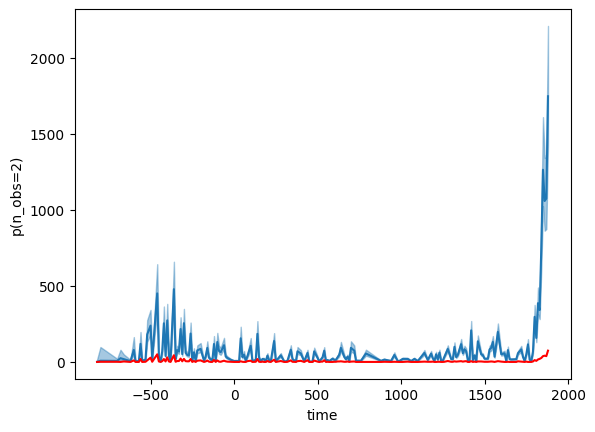

In [43]:
df_filtered = data[data['region_name'] == 'Greek World']

df_filtered = df_filtered.groupby('decade').agg({'f0':'sum', 'f1':'sum', 'f2':'sum', 'min_f0':'sum', 'max_f0':'sum'}).reset_index()
df_filtered['N'] = df_filtered['f1'] + df_filtered['f2'] 
df_filtered['N_unseen'] = df_filtered['f1'] + df_filtered['f2'] + df_filtered['f0']
df_filtered['N_unseen_min'] = df_filtered['f1'] + df_filtered['f2'] + df_filtered['min_f0']
df_filtered['N_unseen_max'] = df_filtered['f1'] + df_filtered['f2'] + df_filtered['max_f0']

fig, ax = plt.subplots()

# Plot predicted line
ax.plot(df_filtered["decade"], df_filtered['N_unseen'], color='C0')
ax.plot(df_filtered["decade"], df_filtered['N'], color='red')


# Plot credibility bands
ax.fill_between(df_filtered["decade"], df_filtered['N_unseen_min'],  df_filtered['N_unseen_max'], alpha=0.4, color='C0')

ax.set(xlabel="time", ylabel="p(n_obs=2)")



### Plot P(Y=2) for every region

[Text(0.5, 0, 'time'), Text(0, 0.5, 'p(n_obs=2)')]

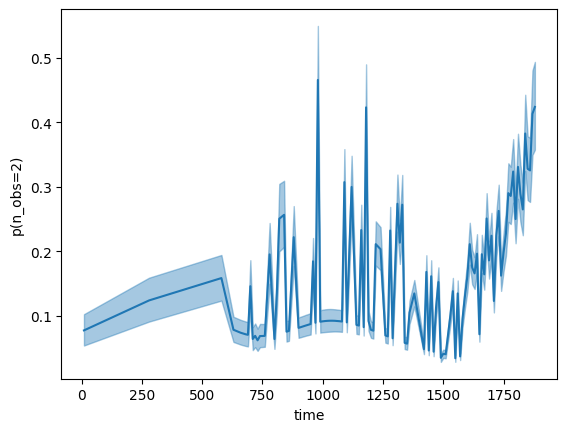

In [44]:
data_f2 = data[['region_name', 'decade', 'y_mean', 'y_min', 'y_max','occupation']].copy()
data_f2 = data_f2.groupby(['region_name', 'decade', 'occupation'])[['y_mean', 'y_min', 'y_max']].mean().reset_index()
data_f2 = data_f2.groupby(['region_name', 'decade'])[['y_mean', 'y_min','y_max']].sum().reset_index()

data_f2_filtered = data_f2[data_f2['region_name']=='Japan']

fig, ax = plt.subplots()

# Plot predicted line
ax.plot(data_f2_filtered["decade"], data_f2_filtered['y_mean'], color='C0')

# Plot credibility bands
ax.fill_between(data_f2_filtered["decade"], data_f2_filtered['y_min'],  data_f2_filtered['y_max'], alpha=0.4, color='C0')

ax.set(xlabel="time", ylabel="p(n_obs=2)")
